In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
%cd /content/drive/MyDrive/Colab Notebooks/first_take

/content/drive/MyDrive/Colab Notebooks/first_take


In [200]:
#===========================================================
# Config
#===========================================================

import yaml

with open('./src/config.yaml') as file:
    config = yaml.safe_load(file.read())

assert config['task'] == 'regression'

df_path_dict = {'train': config['input_dir_root']+'train.csv',
                'test': config['input_dir_root']+'test.csv',
                'sample_submission': config['input_dir_root']+'sample_submission.csv',
                'folds': config['input_dir']+'folds.csv',}

config['feat_excluded'] = [
    config['id'], config['target'],
    'art_series_id',
    'title',
    'description',
    'long_title',
    'more_title',
    'acquisition_date',
    'dating_presenting_date',
    'sub_title'
    ]

In [201]:
config['model']

'lgbm'

In [202]:

#===========================================================
# Metrics
#===========================================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
    
def get_score(y_true, y_pred):
    score = rmsle(y_true, y_pred)
    return score

def custom_eval(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True

#===========================================================
# Model params
#===========================================================

def get_params(n_fold, config):
    if config['model'] == "lgbm":
        # parameters document
        # https://lightgbm.readthedocs.io/en/latest/Parameters.html
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'max_depth': -1,
            'subsample': 0.6,
            'colsample_bytree': 0.4,
            'num_leaves': 32,
            'min_data_in_leaf': 20,
            #'reg_alpha': 0.1,
            #'reg_lambda': 0.1,
            'seed': int(2 ** n_fold)+config['seed'],
            'num_boost_round': 10000,
            'early_stopping_rounds': 200,
            'verbose_eval': 100
            }
    elif config['model'] == "xgb":
        # parameters document
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        params = {
            'objective':'reg:squarederror',
            'eval_metric':'rmse',
            'learning_rate': 0.05,
            'max_depth': 10,
            'subsample': 0.6,
            'colsample_bytree': 0.4,  
            #'min_child_weight':3,
            #'gamma':0.25,
            'seed': int(2 ** n_fold)+config['seed'],
            'num_boost_round': 5000,
            'early_stopping_rounds': 50,
            'verbose_eval': 10
            }
    elif config['model'] == "catb":
        # parameters document
        # https://catboost.ai/docs/concepts/loss-functions.html
        # https://catboost.ai/docs/concepts/python-reference_parameters-list.html
        params = {
            "loss_function": "RMSE",
            "eval_metric": "RMSE",
            "task_type": "CPU",
            'learning_rate': 0.05,
            "iterations": 6000,
            "early_stopping_rounds": 200,
            "verbose": 100,
            "random_seed": int(2 ** n_fold)+config['seed']
            }
    else:
        raise(ValueError("model name is not defined"))
    
    return params


In [203]:
# !pip install catboost
# from catboost import CatBoostClassifier, CatBoostRegressor

In [204]:
#===========================================================
# Library
#===========================================================
import gc
import json
import os
import random
import sys
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import xgboost as xgb
# from catboost import CatBoostClassifier, CatBoostRegressor
from gensim.models.word2vec import Word2Vec
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (GroupKFold, GroupShuffleSplit, KFold,
                                     StratifiedKFold)
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm



In [205]:
#===========================================================
# Utils
#===========================================================

def seed_everything(seed=1996):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


@contextmanager
def timer(name):
    t0 = time.time()
    logger.info(f'[{name}] start')
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')
    logger.info('')


def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger(config['output_dir']+config['fname_log_cv'])

def load_df(path, df_name, config):
    if path.split('.')[-1]=='csv':
        if config['debug']:
            df = pd.read_csv(path, nrows=1000)
        else:
            df = pd.read_csv(path)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    logger.info(f"{df_name} shape / {df.shape} ")
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        logger.info('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def drop_null_columns(train_df, test_df, columns, th=0.99, verbose=False):
    logger.info("original columns: {}".format(len(columns)))
    df = train_df.append(test_df, sort=False)
    drop_col = []
    use_col = []
    for col in columns:
        null_num = df[col].isnull().sum()
        try:
            unique_num = df[col].value_counts()[0]
        except:
            unique_num = 0
        null_rate = (null_num + unique_num) / len(df)
        if null_rate >= th:
            drop_col.append(col)
            if verbose:
                print(col, null_rate)
        else:
            use_col.append(col)
    
    logger.info("{} columns is null.".format(len(drop_col)))
    return use_col


In [206]:
#===========================================================
# Visualize
#===========================================================
def get_importance(feature_importance_df_, top_n=50):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:top_n].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)][["feature", "importance"]].reset_index(drop=True)
    best_features = best_features.sort_values(by="importance", ascending=False)

    return best_features, list(cols)

def display_importances(feature_importance_df_, img_fname):
    best_features, _ = get_importance(feature_importance_df_)

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(img_fname)



In [207]:
#===========================================================
# Model
#===========================================================
def modeling_lightgbm(train_x, train_y, valid_x, valid_y, test_x, config):

    params = config['params']

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                            label=valid_y,
                            free_raw_data=False)

    model = lgb.train(
                params,
                lgb_train,
                valid_sets=[lgb_train, lgb_test],
                valid_names=['train', 'test'],
                num_boost_round=params['num_boost_round'],
                early_stopping_rounds= params['early_stopping_rounds'],
                verbose_eval=params['verbose_eval'],
                feval=config['feval'],
                )

    valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)
    sub_pred = model.predict(test_x, num_iteration=model.best_iteration)
    
    return valid_pred, sub_pred, model.feature_importance(importance_type='gain', iteration=model.best_iteration)

def modeling_xgboost(train_x, train_y, valid_x, valid_y, test_x, config):

    params = config['params']

    xgb_train = xgb.DMatrix(train_x, train_y)
    xgb_test = xgb.DMatrix(valid_x, valid_y)
    
    model = xgb.train(
        params, 
        xgb_train,
        evals=[(xgb_train, 'train'), (xgb_test, 'val')],
        num_boost_round=params['num_boost_round'],
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose_eval=params['verbose_eval'])
    
    valid_pred = model.predict(xgb.DMatrix(valid_x), ntree_limit=model.best_ntree_limit)
    sub_pred = model.predict(xgb.DMatrix(test_x), ntree_limit=model.best_ntree_limit)

    return valid_pred, sub_pred

def modeling_catboost(train_x, train_y, valid_x, valid_y, test_x, config):
    
    params = config['params']

    model = CatBoostRegressor(**params)
    
    model.fit(
        train_x,
        train_y,
        eval_set=(valid_x, valid_y),
        use_best_model=True,
        early_stopping_rounds=params["early_stopping_rounds"],
        verbose=params["verbose"])
    
    valid_pred = model.predict(valid_x)
    sub_pred = model.predict(test_x)
    
    return valid_pred, sub_pred, model.get_feature_importance()
    
def get_model_predict(train_x, train_y, valid_x, valid_y, test_x,  config):

    if config['model'] == "lgbm":
        return modeling_lightgbm(train_x, train_y, valid_x, valid_y, test_x, config)
    
    elif config['model'] == "xgb":
        return modeling_xgboost(train_x, train_y, valid_x, valid_y, test_x, config)

    elif config['model'] == "catb":
        return modeling_catboost(train_x, train_y, valid_x, valid_y, test_x, config)
    
    else:
        raise(ValueError("model name is not defined"))



In [208]:
#===========================================================
# Train and Predict
#===========================================================

def kfold_modeling(train_df, test_df, config):
    # Create arrays and dataframes to store results
    seed_everything(config['seed'])
    folds = load_df(path=df_path_dict['folds'], df_name='folds', config=config)

    oof_preds = np.zeros((train_df.shape[0]))
    sub_preds = np.zeros((test_df.shape[0]))

    if config['model'] in ["lgbm", 'catb']:
        feature_importance_df = pd.DataFrame()

    # k-fold
    scores = []
    for n_fold in range(config['num_folds']):

        logger.info('Starting fold {}'.format(n_fold)) 

        train_idx, valid_idx = folds[folds['folds'] != n_fold].index,  folds[folds['folds'] == n_fold].index
        train_fold = pd.read_pickle(config['input_dir']+f'train_fold{n_fold}.pkl')
        valid_fold = pd.read_pickle(config['input_dir']+f'valid_fold{n_fold}.pkl')
        test_fold = pd.read_pickle(config['input_dir']+f'test_fold{n_fold}.pkl')

        feats = [f for f in test_fold.columns if f not in config['feat_excluded']]
        #feats = drop_null_columns(train_df, test_df, feats)

        config['feats'] = feats
    
        train_x, train_y = train_fold[config['feats']], train_fold[config['target']]
        valid_x, valid_y = valid_fold[config['feats']], valid_fold[config['target']]
        test_x = test_fold[config['feats']]
        
        config['params'] = get_params(n_fold, config)

        if config['custom_eval']:
            config['feval'] = custom_eval
            config['params']['metric'] = "custom"
        logger.info('params: {}'.format(config['params']))
        
        if config['do_log_scale']:
            train_y = np.log1p(train_y)
            valid_y = np.log1p(valid_y)
        
        if n_fold == 0:
            logger.info(config['feats'])
        logger.info('len(trn_idx) : {} len(val_idx) : {} len(feature) : {}'.format(len(train_idx), len(valid_idx), len(config['feats'])))

        if config['model'] in ["lgbm", 'catb']:
            valid_pred, sub_pred, feature_importance = get_model_predict(train_x, train_y, valid_x, valid_y, test_x, config)
        else:
            valid_pred, sub_pred = get_model_predict(train_x, train_y, valid_x, valid_y, test_x, config)
        
        if config['do_log_scale']:
            valid_pred = np.exp(valid_pred) - 1
            sub_pred = np.exp(sub_pred) - 1
            valid_y = np.exp(valid_y) - 1
        
        if config['cat_negative_value']:
            valid_pred = np.where(valid_pred < 0, 0.0, valid_pred)
            sub_pred = np.where(sub_pred < 0, 0.0, sub_pred)

        oof_preds[valid_idx] = valid_pred
        sub_preds += (sub_pred / config['num_folds'])

        if config['model'] in ["lgbm", 'catb']:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = test_x.columns
            fold_importance_df["importance"] = np.log1p(feature_importance)
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        logger.info("{} fold {} score: {:<8.5f}".format(config['model'], n_fold, get_score(valid_y, oof_preds[valid_idx])))
        scores.append(get_score(valid_y, valid_pred))
        logger.info('')

        del train_x, train_y, valid_x, valid_y
        gc.collect()
    
    logger.info("{} CV(all) score: {:<8.5f}".format(config['model'], get_score(train_df[config['target']], oof_preds)))
    logger.info("{} CV(ave) score: {:<8.5f}±{:<8.5f}".format(config['model'], np.mean(scores), np.std(scores)))

    if config['model'] in ["lgbm", 'catb']:
        # display importances
        display_importances(feature_importance_df, config['output_dir']+config['fname_importance'])
        feature_importance_df.to_csv(config['output_dir']+'feature_importance.csv', index=False)

    return oof_preds, sub_preds


Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
Basic Config
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   debug: False
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   task: regression
   input_dir_root: ./input/
   input_dir_root: ./input/
   input_dir_root: ./input/
   input_dir_root: ./input/
   input_dir_root: ./input/
   input_dir_root: ./input/

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.813327	test's rmse: 1.01535
[200]	train's rmse: 0.648522	test's rmse: 0.999003
[300]	train's rmse: 0.538657	test's rmse: 0.993395
[400]	train's rmse: 0.45516	test's rmse: 0.99044
[500]	train's rmse: 0.387908	test's rmse: 0.990413
[600]	train's rmse: 0.334256	test's rmse: 0.989098
[700]	train's rmse: 0.291883	test's rmse: 0.988191
[800]	train's rmse: 0.256488	test's rmse: 0.986826
[900]	train's rmse: 0.226654	test's rmse: 0.986017
[1000]	train's rmse: 0.201305	test's rmse: 0.985351
[1100]	train's rmse: 0.179695	test's rmse: 0.985312
[1200]	train's rmse: 0.160171	test's rmse: 0.985236
[1300]	train's rmse: 0.143853	test's rmse: 0.985437
Early stopping, best iteration is:
[1186]	train's rmse: 0.16267	test's rmse: 0.985065


lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 
lgbm fold 0 score: 0.98482 

















Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
Starting fold 1
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 1998, 'num_boost_round'

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.810883	test's rmse: 1.03786
[200]	train's rmse: 0.646592	test's rmse: 1.01772
[300]	train's rmse: 0.537416	test's rmse: 1.01005
[400]	train's rmse: 0.45453	test's rmse: 1.00751
[500]	train's rmse: 0.388329	test's rmse: 1.00649
[600]	train's rmse: 0.335092	test's rmse: 1.00421
[700]	train's rmse: 0.290046	test's rmse: 1.00315
[800]	train's rmse: 0.253737	test's rmse: 1.00214
[900]	train's rmse: 0.223273	test's rmse: 1.00254
[1000]	train's rmse: 0.197769	test's rmse: 1.00228
Early stopping, best iteration is:
[829]	train's rmse: 0.244	test's rmse: 1.00186


lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 
lgbm fold 1 score: 1.00167 

















Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
Starting fold 2
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2000, 'num_boost_round'

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.805289	test's rmse: 1.05192
[200]	train's rmse: 0.640801	test's rmse: 1.03965
[300]	train's rmse: 0.53128	test's rmse: 1.03405
[400]	train's rmse: 0.448494	test's rmse: 1.03082
[500]	train's rmse: 0.382935	test's rmse: 1.02957
[600]	train's rmse: 0.331061	test's rmse: 1.02834
[700]	train's rmse: 0.288033	test's rmse: 1.02669
[800]	train's rmse: 0.251634	test's rmse: 1.02715
[900]	train's rmse: 0.221969	test's rmse: 1.02679
Early stopping, best iteration is:
[700]	train's rmse: 0.288033	test's rmse: 1.02669


lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 
lgbm fold 2 score: 1.02655 

















Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
Starting fold 3
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2004, 'num_boost_round'

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.809139	test's rmse: 1.03882
[200]	train's rmse: 0.644661	test's rmse: 1.02428
[300]	train's rmse: 0.535619	test's rmse: 1.02427
[400]	train's rmse: 0.450736	test's rmse: 1.02356
[500]	train's rmse: 0.385327	test's rmse: 1.02414
Early stopping, best iteration is:
[336]	train's rmse: 0.503032	test's rmse: 1.02315


lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 
lgbm fold 3 score: 1.02314 

















Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
Starting fold 4
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2012, 'num_boost_round'

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.796648	test's rmse: 1.09529
[200]	train's rmse: 0.636222	test's rmse: 1.08055
[300]	train's rmse: 0.530028	test's rmse: 1.07574
[400]	train's rmse: 0.449342	test's rmse: 1.076
[500]	train's rmse: 0.384601	test's rmse: 1.07459
[600]	train's rmse: 0.332842	test's rmse: 1.07278
[700]	train's rmse: 0.290001	test's rmse: 1.07218
[800]	train's rmse: 0.254593	test's rmse: 1.07217
[900]	train's rmse: 0.225681	test's rmse: 1.07186
[1000]	train's rmse: 0.200976	test's rmse: 1.07154
[1100]	train's rmse: 0.178589	test's rmse: 1.07154
[1200]	train's rmse: 0.160777	test's rmse: 1.07178
[1300]	train's rmse: 0.145386	test's rmse: 1.07178
Early stopping, best iteration is:
[1126]	train's rmse: 0.173724	test's rmse: 1.07139


lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 
lgbm fold 4 score: 1.07132 

















lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(all) score: 1.02191 
lgbm CV(ave) s

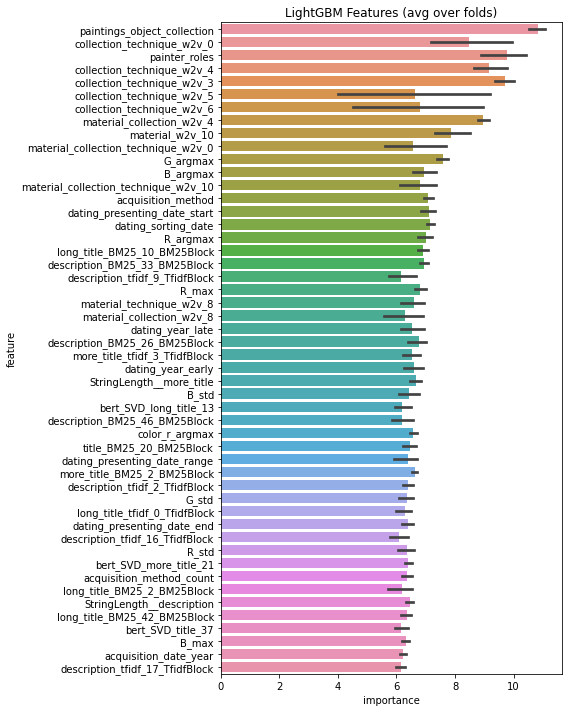

In [209]:
#===========================================================
# Main
#===========================================================
def main():
    logger.info('Basic Config')
    for k, v in config.items():
        logger.info('   {}: {}'.format(k, v))
    logger.info('')

    with timer('Data Loading'):
        train = load_df(path=df_path_dict['train'], df_name='train', config=config)
        #train = reduce_mem_usage(train)
        test = load_df(path=df_path_dict['test'], df_name='test', config=config)
        #test = reduce_mem_usage(test)
        sample_submission = load_df(path=df_path_dict['sample_submission'], df_name='sample_submission', config=config)
    

    with timer('Run Models'):
        if config['num_seed'] > 1:
            oof_preds = []
            sub_preds = []
            for idx in range(config['num_seed']):
                config['seed'] += idx
                oof_pred, sub_pred = kfold_modeling(train, test, config)
                oof_preds.append(oof_pred,)
                sub_preds.append(sub_pred)
            
            oof_pred = np.mean(oof_preds, axis=0)
            sub_pred = np.mean(sub_preds, axis=0)

            logger.info("{} CV(RSA) score: {:<8.5f}".format(config['model'], get_score(train[config['target']], sub_pred)))
        else:
            oof_pred, sub_pred = kfold_modeling(train, test, config)

        train['pred'] = oof_pred
        test['pred'] = sub_pred
        train[[config['id'], 'pred']].to_pickle(config['output_dir']+'oof.pkl')
        test[[config['id'], 'pred']].to_pickle(config['output_dir']+'sub.pkl')
    
    with timer("submission"):
        # submission
        sample_submission[config['target']] = sub_pred
        sample_submission.to_csv(config['output_dir']+config['fname_submission'], index=False)

if __name__ == "__main__":
    main()
